In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip

from PIL import ImageFont

#### Author:
Simon Hackl, 28.02.2021

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S7_assemblyEvaluation.sh` script regarding genes predicted with GeneMarkS. In order to use this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

####  Comparing predicted with annotated genes:

The `Quast` reports of the non sub-sample reference data sets revealed, that for the long read assemblies of the CFT073 and MGH78578 references many more genes were predicted than annotated genes are present. To investigate this, this script is used to caclculate:
- the distribution of gene lengths of annotated and predicted genes.
- the number of predicted genes that overlap reference genes. A predicted gene is considered to overlap a reference gene if at least 90% of it is contained in any reference gene (regarding the genomic positions, not the bases).  
It was hypothesized that errors in the long read sequences led to an interruption of detecting contiguos gene sequences. 

In [2]:
def plotGeneIntersections( genes, prediction, color="crimson", subtitle="", overlap=0.9 ) :
    ''' This method reads the files of annotated and predicted genes position in an assembly and:
    * visualizes the distribution of gene lengths.
    * the number of predicted genes that are fully contained in reference genes.
    * the number of predicted genes that are located outside of reference gene positions.
    
    Parameters
    ----------
    genes : str
        The path to a ...genomic_features_any.txt file generated with Quast. These files contain
        information about the position of annotated genes in the respective assembly.
        
    prediction : str
        The path to a ..._genemark_genes.gff.gz file generated with Quast. These files contain
        information about the position of predicted genes in the respective assembly.
        
    color : str
        A matplotlib color name for coloring the generated plots. Default is "cornflowerblue".
        
    subtitle : str
        A string that is appended to the title of each plot.
    '''

    # First, read in information of reference/annotated genes, i.e. pairs of start and stop locations.
    genes = pd.read_csv(open(genes), delimiter='\t')
    genes.drop( 0, inplace = True )
    genes.drop( "Unnamed: 1", axis = 1, inplace = True )
    genes.drop( "Type", axis = 1, inplace = True )
    genes.drop( "Contig", axis = 1, inplace = True )
    genes.rename( columns = { "ID or #":"ID", "Start":"s", "End":"e" }, inplace = True )
    genes = genes[ genes.ID.str.startswith( "gene" ) ]
    
    # Second, read in information of predicted genes, i.e. pairs of start and stop locations.
    with gzip.open(prediction) as prediction :
        line = prediction.readline( ).decode( "UTF-8" )
        IDs = [ ]
        starts = [ ]
        ends = [ ]
        strands = [ ]
        while line :
            if not ( line.startswith('##') or line.strip( ) == '' ) :
                splitLine = line.strip( ).split('\t')
                IDs.append( splitLine[ 8 ] )
                starts.append( splitLine[ 3 ] )
                ends.append( splitLine[ 4 ] )
                strands.append( splitLine[ 6 ] )
            line = prediction.readline( ).decode( "UTF-8" )
    d = { "ID" : IDs, "s" : starts, "e" : ends, "strand" : strands }
    predicted = pd.DataFrame( data = d )
    
    # Process information from true and predicted genes.
    genesIntervals = [ ] # Stores pairs of start and stop position of reference genes.
    predictedIntervals = [ ] # Stores pairs of start and stop position of predicted genes.
    genesLen = [ ] # Stores the length of reference genes.
    predictedLen = [ ] # Stores the length of predicted genes.
    for gs, ge in zip( genes.s.tolist( ), genes.e.tolist( ) ) :
        gs = int( gs )
        ge = int( ge )
        genesIntervals.append( ( gs, ge ) )
        genesLen.append( ge - gs )
    for ps, pe in zip( predicted.s.tolist( ), predicted.e.tolist( ) ) :
        ps = int( ps )
        pe = int( pe )
        predictedIntervals.append( ( ps, pe ) )
        predictedLen.append( pe - ps )
    
        
    genesCount = { }
    g = 1
    # For each reference gene start and stop position...
    for gs, ge in genesIntervals :
        count = 0 # Stores the count of fully contained predicted genes for the current reference gene.
        # ...iterate over all predicted genes start and stop position...
        for ps, pe in predictedIntervals :
            # ...if the predicted genes start is greater than the current reference genes start,
            # it can not be contained. The current count is stored and the next reference
            # gene is considered.
            if ps > ( ge + overlap ) :
                genesCount[ g ] = count
                count = 0
                g += 1
                break
            # ...if the predicted genes end is downstram of the current reference genes start,
            # we can head on to the next predicted gene.
            elif pe < gs :
                continue
            # ...if the predicted gene is fully contained, all positions overlap.
            elif ps >= gs and pe <= ge :
                overlappingPositions = pe - ps
            # ... if the predicted gene overlaps a prefix of a reference gene, the overlap is set to the end position
            # of the predicted gene minus the start position of the reference gene.
            elif ps < gs and pe < ge :
                overlappingPositions = pe - gs
            # ... if the predicted gene overlaps a suffix of a reference gene, the overlap is set to the end position
            # of the reference gene minus the start position of the predicted gene.
            elif ps > gs and pe > ge :
                overlappingPositions = ge - ps
            # ... if the predicted gene spans over the full reference gene, the overlap is set to all positions of
            # the reference gene.
            elif ps < gs and pe > ge :
                overlappingPositions = ge - gs
            # If the overlapping positions are at least 90% of all predicted gene positions, the count is increased.
            if overlappingPositions / ( pe - ps ) >= overlap :
                count += 1
                
    # Count number of predicted genes that do not overlap any reference genes:
    predictedGenes = len( predictedLen )
    containedPredictedGenes = sum( list( genesCount.values( ) ) )
    anyOutside = ( predictedGenes - containedPredictedGenes ) > 0
    
    # Plot histogram of overlapping predicted genes.
    plt.figure( figsize=( 9, 9 / 1.618 ) )
    values, bins, _ = plt.hist( list( genesCount.values( ) ), align="left", bins=list( range( 0, max( list( genesCount.values( ) ) ) + 1 ) ), color=color, rwidth=0.8 )
    if anyOutside : # annotate non overlapping predicted genes.
        plt.annotate(
            str( predictedGenes - containedPredictedGenes ) + " non overlapping predicted genes counted",
            xy = (0.45, 0.85),
            xycoords = 'figure fraction',
            size = 12,
            ha = 'left',
            va = 'center',
            bbox = dict(boxstyle='round', fc='w')
        )
        
    xticks = list( range( 0, max( list( genesCount.values( ) ) ) + 1 ) )
    plt.xticks( xticks[::2] if len( xticks ) > 20 else xticks, fontsize=13 )
    plt.xlabel( "number of predicted genes with at least " + str( overlap * 100 ) + "% overlap", fontsize=15 )

    plt.yticks( fontsize=13 )
    plt.ylabel( "number of reference genes", fontsize=15 )
    plt.yscale("log")
    
    plt.title( "Number of reference genes grouped by number of\noverlapping predicted genes, " + subtitle, fontsize=15 );
    plt.show( )
    
    # Plot histogram of gene length distribution.
    plt.figure( figsize=( 9, 9 / 1.618 ) )
    maxGeneLen = max( [ max( genesLen ), max( predictedLen ) ] )
    binBorders = list( np.arange( 0, maxGeneLen + round( maxGeneLen / 20, -2 ) , round( maxGeneLen / 20, -2 ) ) )
    plt.hist( genesLen, label="reference genes", align="mid", rwidth=0.5, bins=binBorders, color="black", alpha=0.6 )
    plt.hist( predictedLen, label="predicted genes", align="mid", rwidth=0.2, bins=binBorders, color=color )

    plt.xticks( binBorders[::2], rotation=-50, fontsize=15, ha="center" )
    plt.xlabel( "gene length [bp]", fontsize=16 )

    plt.yticks( fontsize=15 )
    plt.ylabel( "number of genes", fontsize=15 )
    plt.yscale("log")

    plt.legend( fontsize=16 )

    plt.title( "Distribution of gene lengths, " + subtitle, fontsize=16 );
    plt.show( )

In the following the method `plotGeneIntersections` is invoked on each assembler and each sample.

In [3]:
# List of all assembler names as used in the Quast report file names.
assemblers = [ "canu", "canu_medaka", "flye", "raven", "unicycler-longread", "unicycler-hybrid", "trycycler", "trycycler_medaka", "trycycler_medaka_pilon" ]
# Dictionary to map assembler names above to adjusted names for plotting.
assemblerLabels = {
    "canu" : "canu",
    "canu_medaka" : "canu (+ medaka)",
    "flye" : "flye",
    "raven" : "raven",
    "unicycler-longread" : "unicycler longread",
    "unicycler-hybrid" : "unicycler hybrid",
    "trycycler" : "trycycler",
    "trycycler_medaka" : "trycycler (+ medaka)",
    "trycycler_medaka_pilon" : "trycycler (+ medaka, pilon)"
}

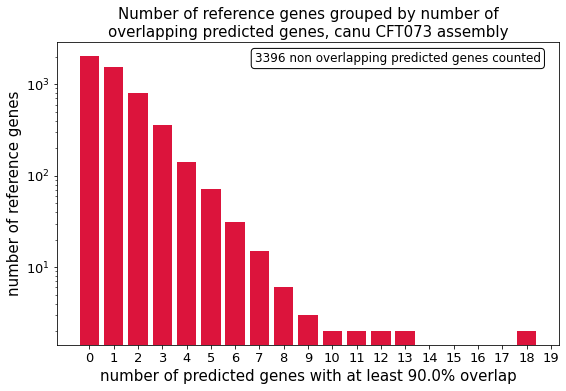

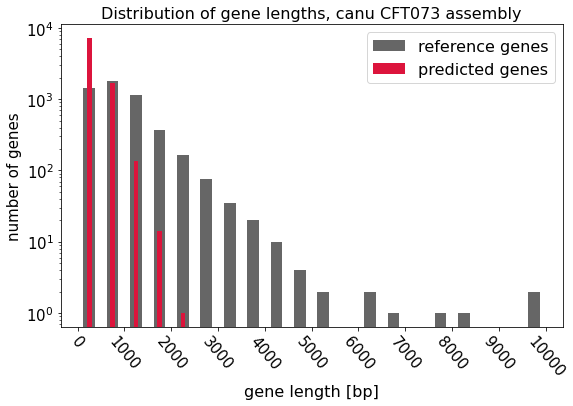

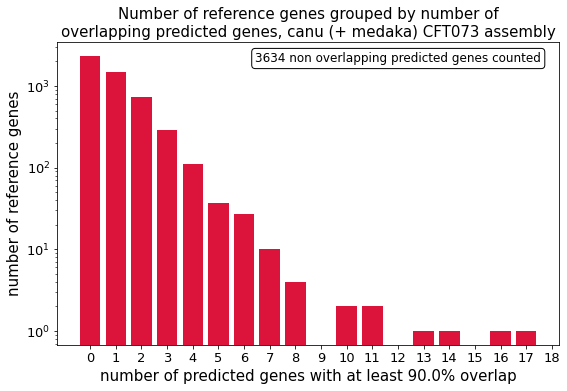

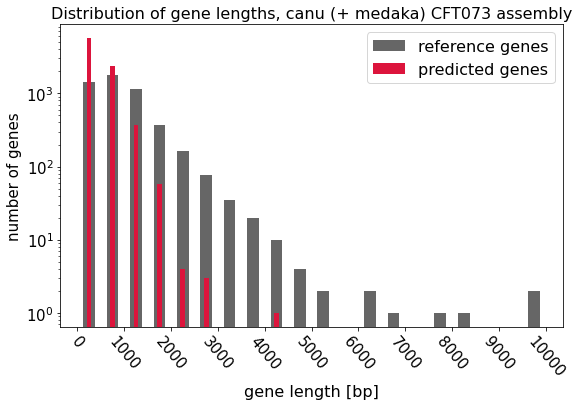

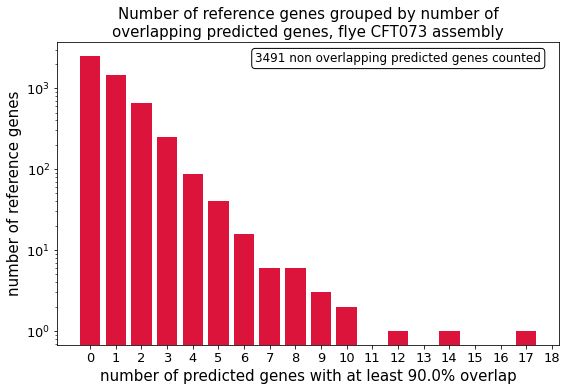

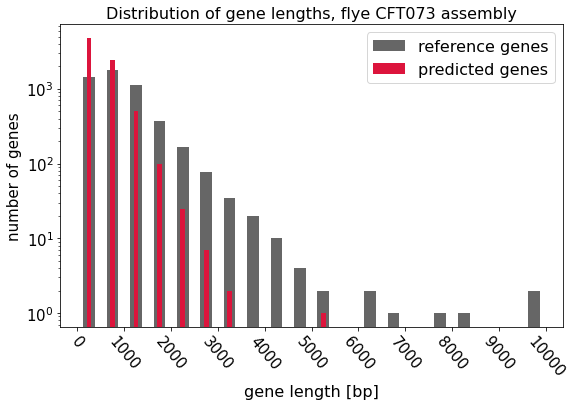

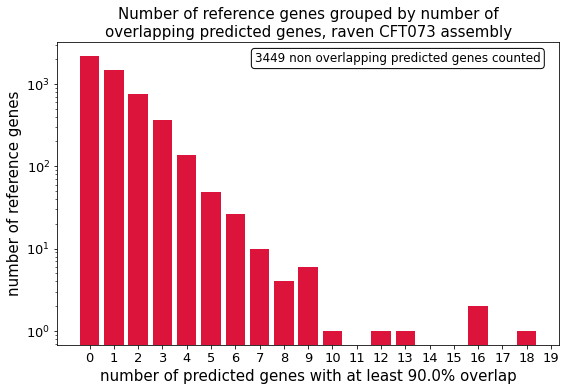

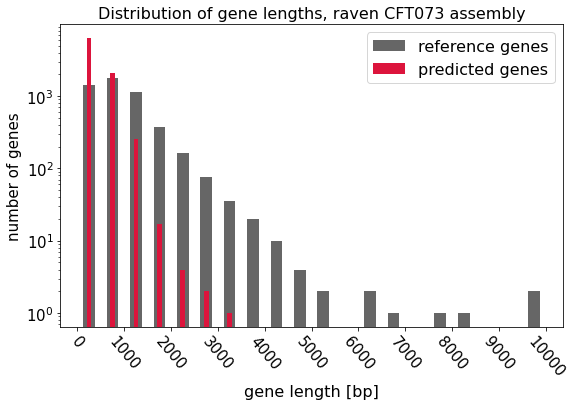

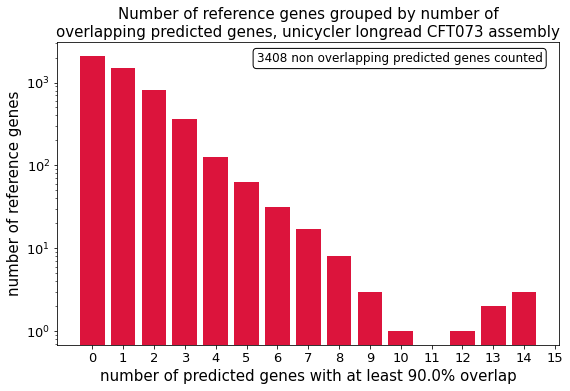

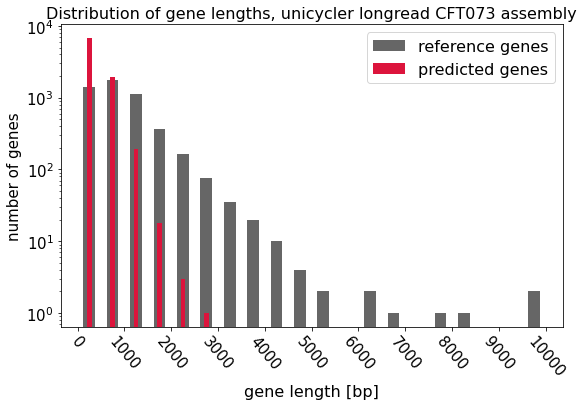

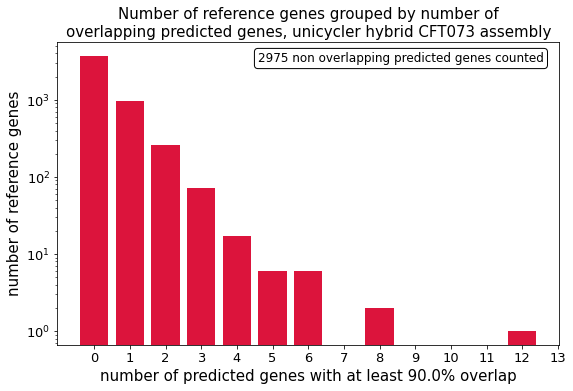

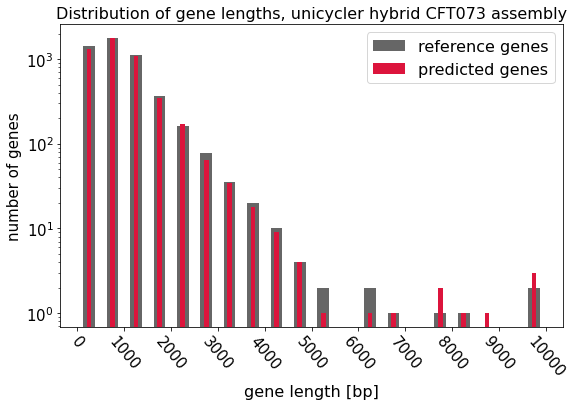

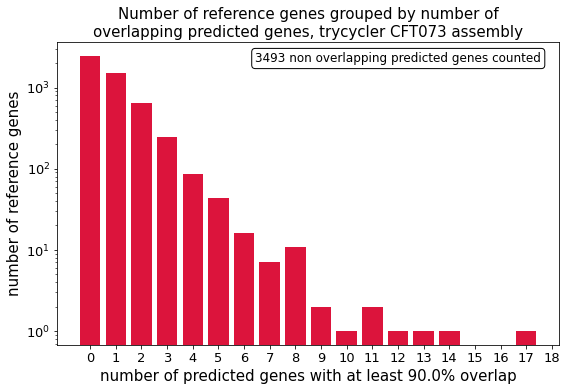

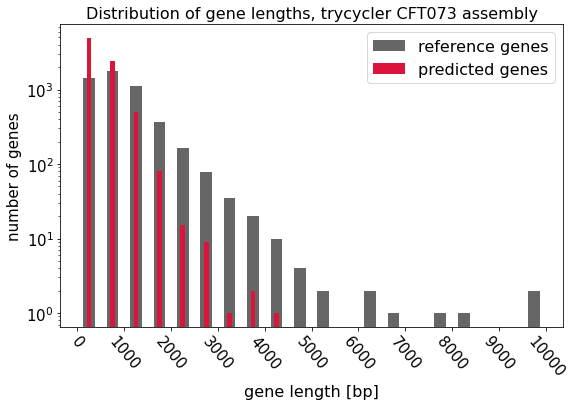

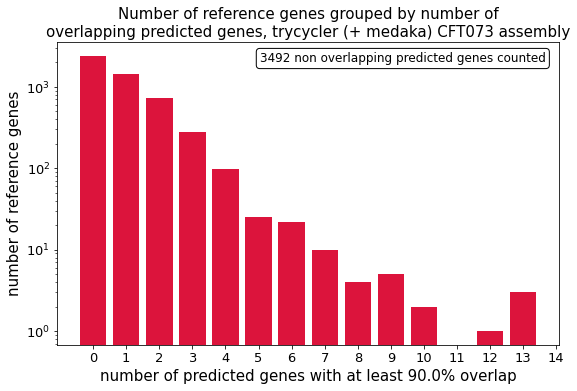

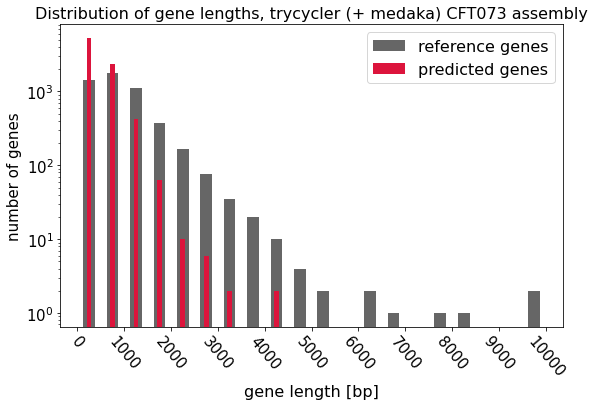

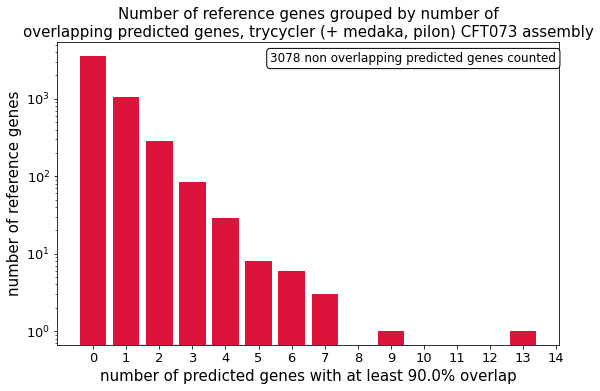

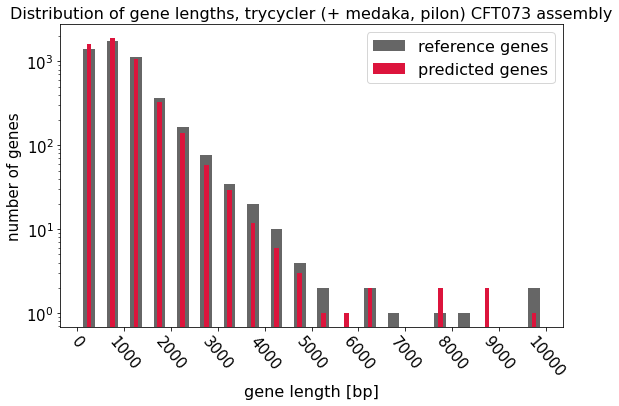

In [4]:
# Run on each assembly of CFT073
sample = "CFT073"
for assembler in assemblers :
    plotGeneIntersections(
        "./results/quast/" + sample + "/genome_stats/" + assembler + "_genomic_features_any.txt",
        "./results/quast/" + sample + "/predicted_genes/" + assembler + "_genemark_genes.gff.gz",
        subtitle=" ".join( [ assemblerLabels[ assembler ], sample ] ) + " assembly"
    )

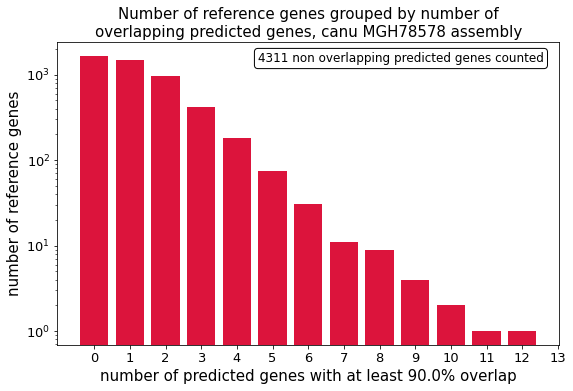

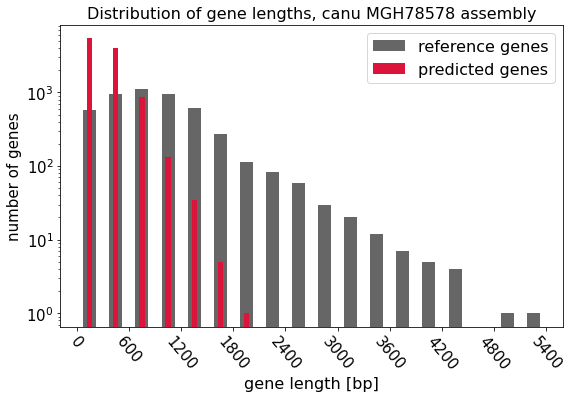

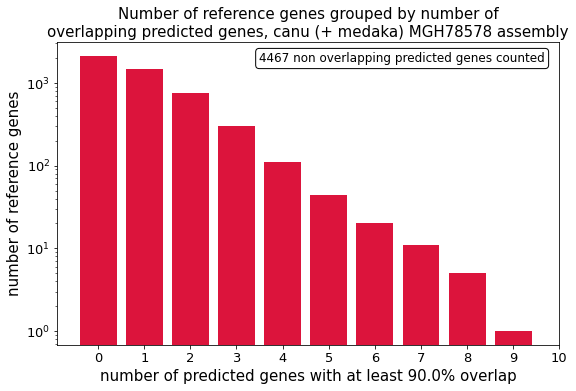

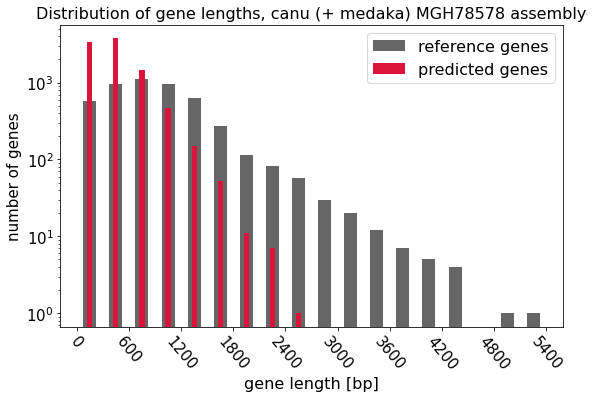

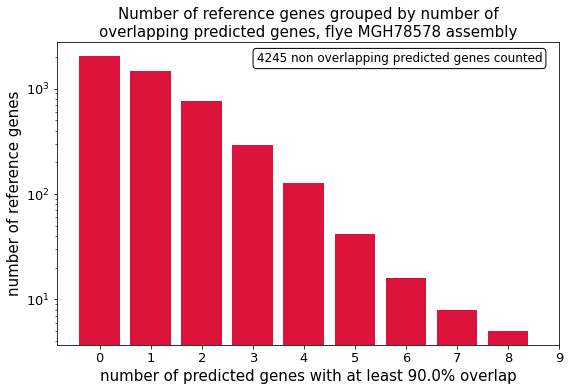

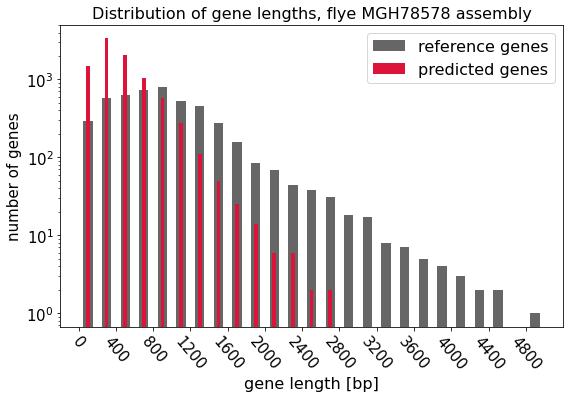

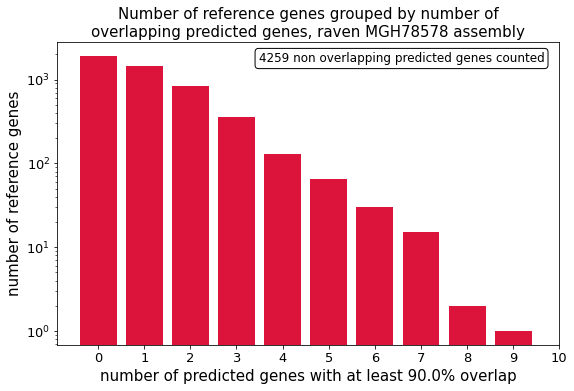

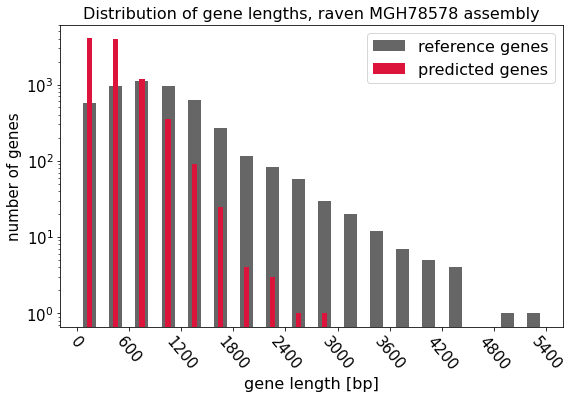

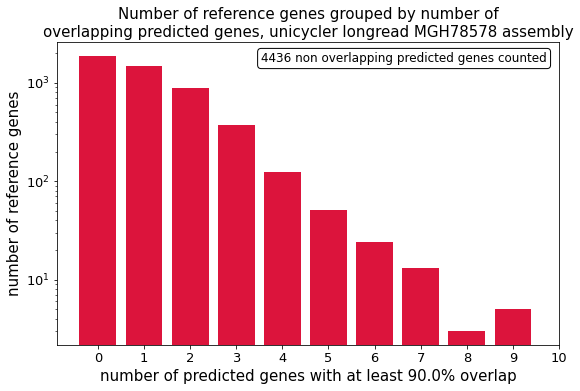

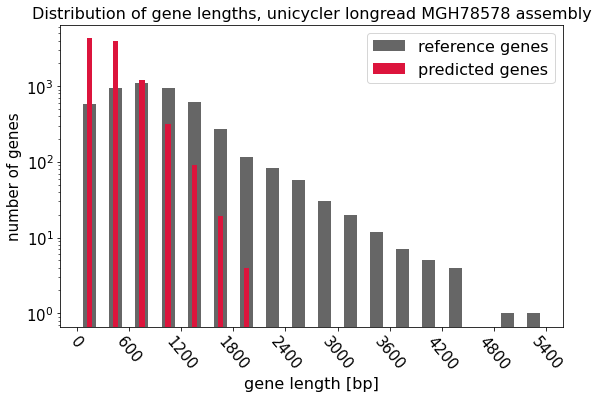

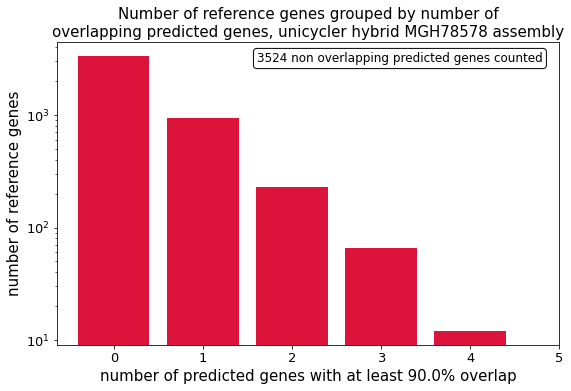

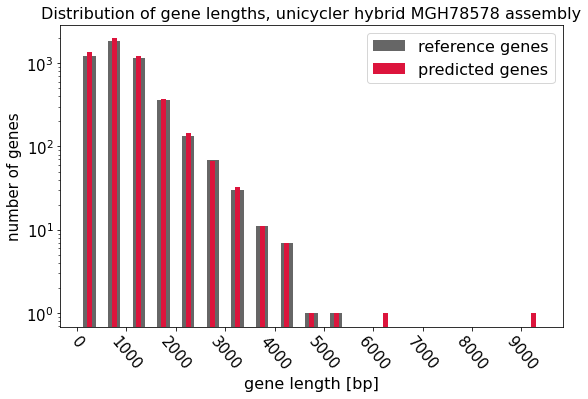

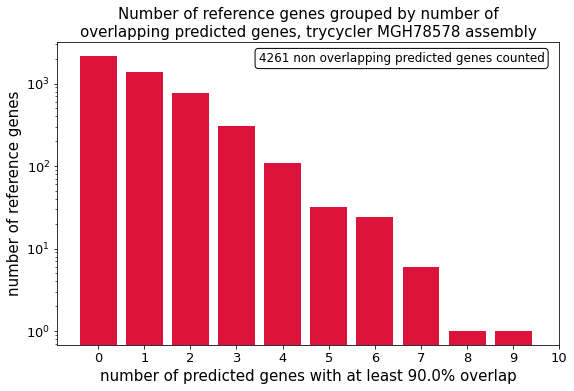

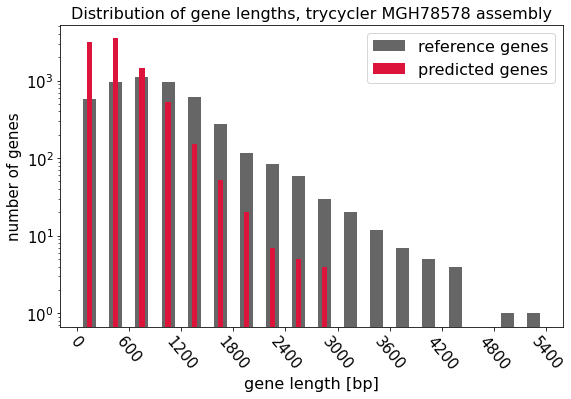

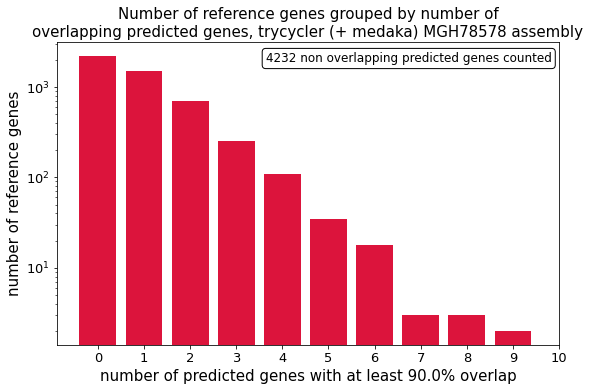

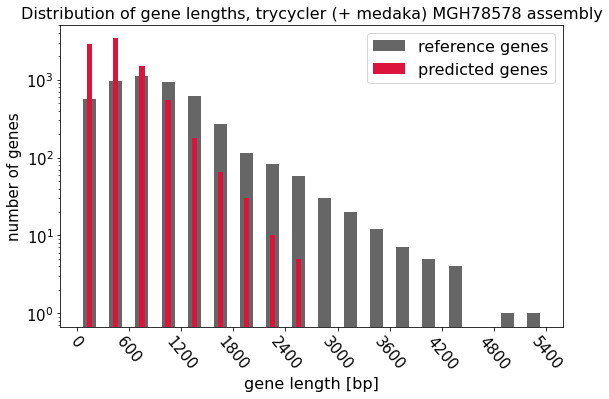

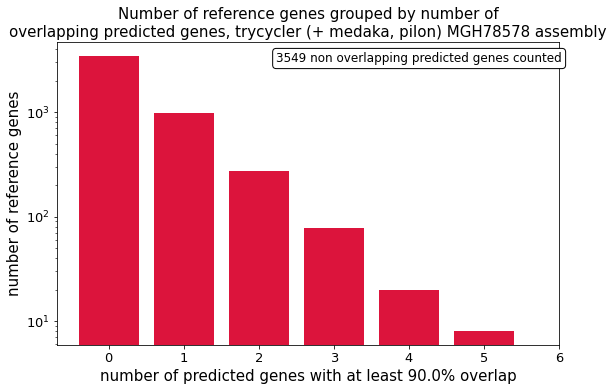

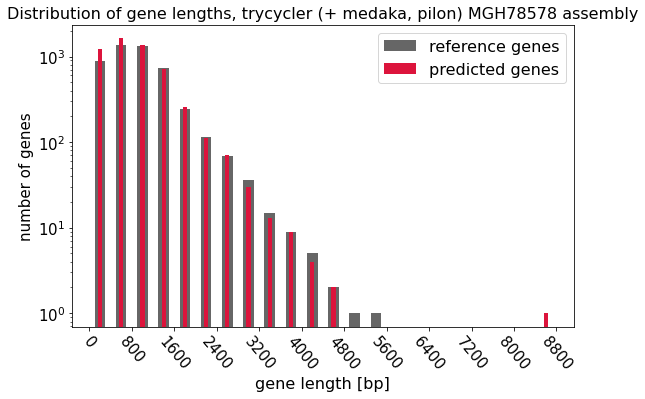

In [5]:
# Run on each assembly of MGH78578
sample = "MGH78578"
for assembler in assemblers :
    plotGeneIntersections(
        "./results/quast/" + sample + "/genome_stats/" + assembler + "_genomic_features_any.txt",
        "./results/quast/" + sample + "/predicted_genes/" + assembler + "_genemark_genes.gff.gz",
        subtitle=" ".join( [ assemblerLabels[ assembler ], sample ] ) + " assembly"
    )